# Psuedobulk DESeq2 with decoupler and PyDESeq2
**Authorship:** Adam Klie (last updated: 08/27/2023)<br>
***
**Description:** This notebook performs a

# Set-up

In [1]:
# Global Imports
import os
import sys
import yaml
import random
import time
import datetime
import logging
import scanpy as sc
import decoupler as dc
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Import DESeq2
import pydeseq2
from pydeseq2.dds import DeseqDataSet
from pydeseq2.ds import DeseqStats

# Plotting options, change to your liking
sc.settings.set_figure_params(dpi=200, frameon=False)
sc.set_figure_params(dpi=200)
sc.set_figure_params(figsize=(4, 4))
sc.settings.verbosity = 3

The history saving thread hit an unexpected error (DatabaseError('database disk image is malformed')).History will not be written to the database.


In [2]:
# Inputs
input_h5ad_path = "/cellar/users/aklie/data/datasets/igvf_sc-islet_10X-Multiome/analysis/2024_01_21/conditions_within_batch/ext4/pseudobulk_functional_analysis/pseudobulk/500_cells/pdatas/pseudobulk_SC.beta_filtered_genes.h5ad"
condition_col = "condition"

In [3]:
# Outputs
outdir_path = "/cellar/users/aklie/data/datasets/igvf_sc-islet_10X-Multiome/analysis/2024_01_21/conditions_within_batch/ext4/pseudobulk_functional_analysis/deseq2/500_cells/SC.beta-sample_timepoint"
if not os.path.exists(outdir_path):
    os.makedirs(outdir_path)

In [4]:
# Method params
design_factors = [condition_col, "timepoint"]
contunious_factors = None
reference_factor = 'condition'
reference_value = 'control'
refit_cooks = True
n_cpus = 3

In [5]:
# Make a params file
data_params = {
    "input_h5ad_path": input_h5ad_path,
    "outdir_path": outdir_path,
}
method_params = {
    "design_factors": design_factors,
    "contunious_factors": contunious_factors,
    "reference_factor": reference_factor,
    "reference_value": reference_value,
    "refit_cooks": refit_cooks,
    "n_cpus": n_cpus,
}
version_params = {
    "Python": sys.version[:5],
    "Scanpy": sc.__version__,
    "decoupler": dc.__version__,
    "pydeseq2": pydeseq2.__version__,
}
params = {"data": data_params, "run": method_params, "versions": version_params}
params_file = os.path.join(outdir_path,"deseq2_params.yaml")
if not os.path.exists(os.path.join(outdir_path, params_file)):
    with open(os.path.join(outdir_path, params_file), "w") as f:
        yaml.dump(params, f)
else:
    print("params.yaml already exists, will not overwrite")

# Load data

In [6]:
# The data to load from pseudobulk
pdata = sc.read_h5ad(input_h5ad_path)
pdata

AnnData object with n_obs × n_vars = 6 × 14412
    obs: 'gex_umis_count_cellranger', 'gex_genes_count_cellranger', 'outlier', 'mt_outlier', 'scrublet_predicted_doublet', 'scDblFinder_doublet_class', 'scDblFinder_predicted_doublet', 'cellranger_predicted_doublet', 'doublet_filter', 'sample', 'integrated_manual_cellid_annotation', 'batch', 'timepoint', 'condition', 'pseudobulk', 'psbulk_n_cells', 'psbulk_counts'
    var: 'sctransform_genes', 'n_cells'
    layers: 'psbulk_props'

In [7]:
# Double check your covariates
pdata.obs.condition.value_counts(), pdata.obs.integrated_manual_cellid_annotation.value_counts()

(3-cyt      3
 control    3
 Name: condition, dtype: int64,
 SC.beta    6
 Name: integrated_manual_cellid_annotation, dtype: int64)

# Run DESeq2

In [4]:
DeseqDataSet?

Init signature:
DeseqDataSet(
    *,
    adata: Union[anndata._core.anndata.AnnData, NoneType] = None,
    counts: Union[pandas.core.frame.DataFrame, NoneType] = None,
    metadata: Union[pandas.core.frame.DataFrame, NoneType] = None,
    design_factors: Union[str, List[str]] = 'condition',
    continuous_factors: Union[List[str], NoneType] = None,
    ref_level: Union[List[str], NoneType] = None,
    min_mu: float = 0.5,
    min_disp: float = 1e-08,
    max_disp: float = 10.0,
    refit_cooks: bool = True,
    min_replicates: int = 7,
    beta_tol: float = 1e-08,
    n_cpus: Union[int, NoneType] = None,
    batch_size: int = 128,
    joblib_verbosity: int = 0,
    quiet: bool = False,
) -> None
Docstring:     
A class to implement dispersion and log fold-change (LFC) estimation.

The DeseqDataSet extends the `AnnData class
<https://anndata.readthedocs.io/en/latest/generated/anndata.AnnData.html#anndata.AnnData>`_.
As such, it implements the same methods and attributes, in addition to 

Error in atexit._run_exitfuncs:
Traceback (most recent call last):
  File "/cellar/users/aklie/opt/miniconda3/envs/scverse-lite-py38/lib/python3.8/site-packages/IPython/core/history.py", line 804, in writeout_cache
    self._writeout_input_cache(conn)
  File "/cellar/users/aklie/opt/miniconda3/envs/scverse-lite-py38/lib/python3.8/site-packages/IPython/core/history.py", line 787, in _writeout_input_cache
    conn.execute("INSERT INTO history VALUES (?, ?, ?, ?)",
sqlite3.DatabaseError: database disk image is malformed


In [8]:
# Build DESeq2 object
dds = DeseqDataSet(
    adata=pdata,
    design_factors=design_factors,
    continuous_factors=contunious_factors,
    ref_level=[reference_factor, reference_value],  # [factor, value]
    refit_cooks=refit_cooks,
    n_cpus=n_cpus,
)

In [9]:
# Compute LFCs
dds.deseq2()

Fitting size factors...
... done in 0.00 seconds.

Fitting dispersions...
... done in 37.53 seconds.

Fitting dispersion trend curve...
... done in 3.81 seconds.

/cellar/users/aklie/opt/miniconda3/envs/scverse-lite-py38/lib/python3.8/site-packages/pydeseq2/dds.py:363: UserWarning: As the residual degrees of freedom is less than 3, the distribution of log dispersions is especially asymmetric and likely to be poorly estimated by the MAD.
  self.fit_dispersion_prior()
Fitting MAP dispersions...
... done in 44.37 seconds.

Fitting LFCs...
... done in 3.08 seconds.

Refitting 0 outliers.



In [11]:
# Check available contrasts
contrast_factors = pdata.obs[reference_factor].unique()
contrast_factors

array(['3-cyt', 'control'], dtype=object)

Running DESeq2 for 3-cyt vs control


Running Wald tests...


Log2 fold change & Wald test p-value: condition 3-cyt vs control


... done in 0.76 seconds.



,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
A1BG,10.905034,-0.297952,0.239605,-1.243514,2.136785e-01,3.559707e-01
A1BG-AS1,23.050985,0.779842,0.152616,5.109844,3.224251e-07,3.946867e-06
A1CF,476.182281,-0.370195,0.035174,-10.524691,6.647920e-26,8.884446e-24
A3GALT2,10.027637,0.232714,0.236739,0.982999,3.256081e-01,4.830665e-01
AAAS,14.643253,0.207881,0.198642,1.046511,2.953251e-01,4.500327e-01
...,...,...,...,...,...,...
ZUP1,44.699970,0.071300,0.121067,0.588929,5.559091e-01,6.930373e-01
ZW10,16.369032,0.149052,0.163159,0.913536,3.609605e-01,5.174995e-01
ZXDC,125.579849,-0.038606,0.059618,-0.647555,5.172728e-01,6.611646e-01
ZYG11B,118.036903,-0.032793,0.072752,-0.450745,6.521735e-01,7.701039e-01


/cellar/users/aklie/opt/miniconda3/envs/scverse-lite-py38/lib/python3.8/site-packages/pandas/plotting/_matplotlib/core.py:1114: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(
Fitting MAP LFCs...


Shrunk log2 fold change & Wald test p-value: condition 3-cyt vs control


... done in 2.93 seconds.



,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
A1BG,10.905034,-0.134360,0.199727,-1.243514,2.136785e-01,3.559707e-01
A1BG-AS1,23.050985,0.723859,0.154180,5.109844,3.224251e-07,3.946867e-06
A1CF,476.182281,-0.365766,0.035202,-10.524691,6.647920e-26,8.884446e-24
A3GALT2,10.027637,0.100903,0.191787,0.982999,3.256081e-01,4.830665e-01
AAAS,14.643253,0.109308,0.171229,1.046511,2.953251e-01,4.500327e-01
...,...,...,...,...,...,...
ZUP1,44.699970,0.051863,0.111120,0.588929,5.559091e-01,6.930373e-01
ZW10,16.369032,-0.144270,0.333246,0.913536,3.609605e-01,5.174995e-01
ZXDC,125.579849,-0.144270,0.333246,-0.647555,5.172728e-01,6.611646e-01
ZYG11B,118.036903,-0.028890,0.070150,-0.450745,6.521735e-01,7.701039e-01


/cellar/users/aklie/opt/miniconda3/envs/scverse-lite-py38/lib/python3.8/site-packages/pandas/plotting/_matplotlib/core.py:1114: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(


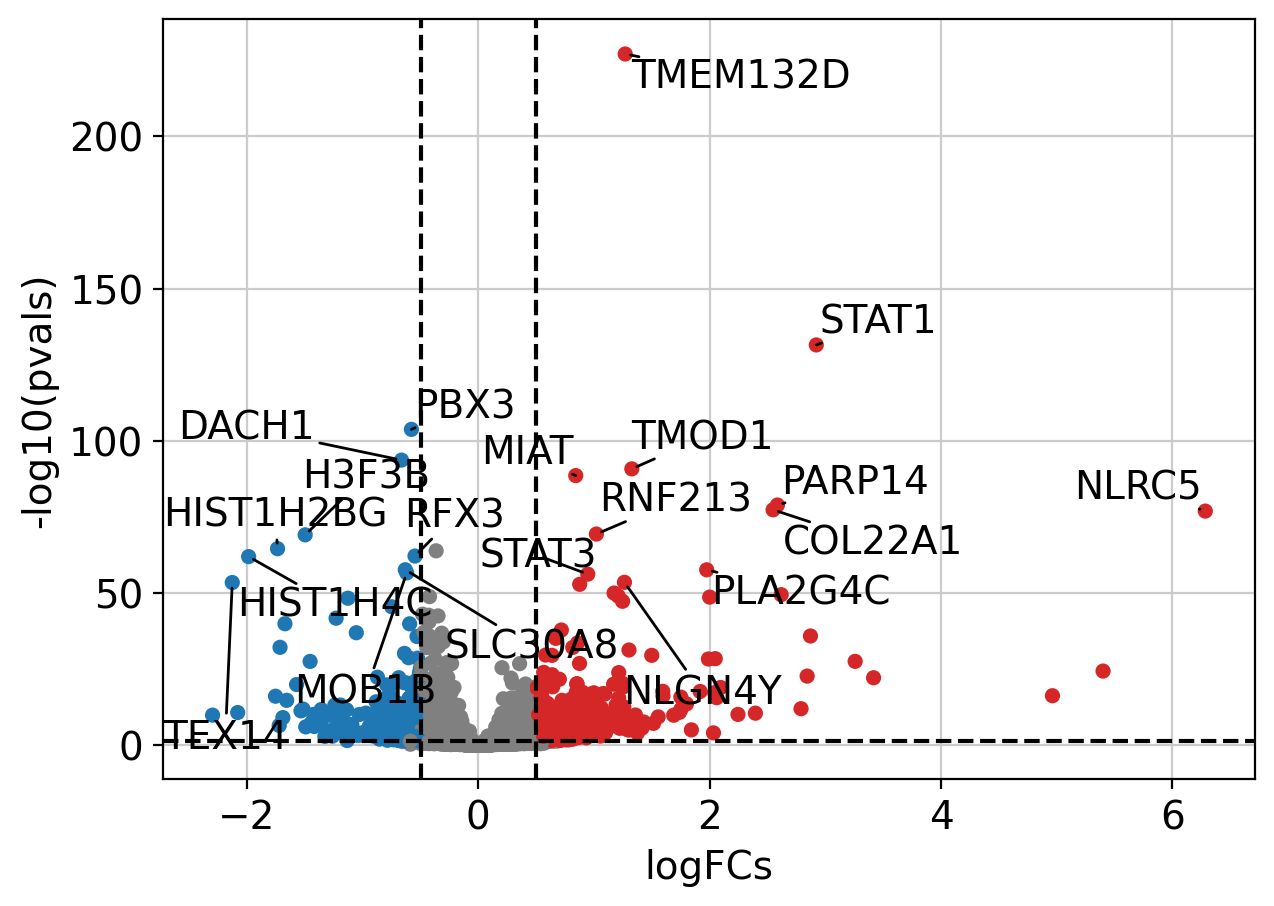

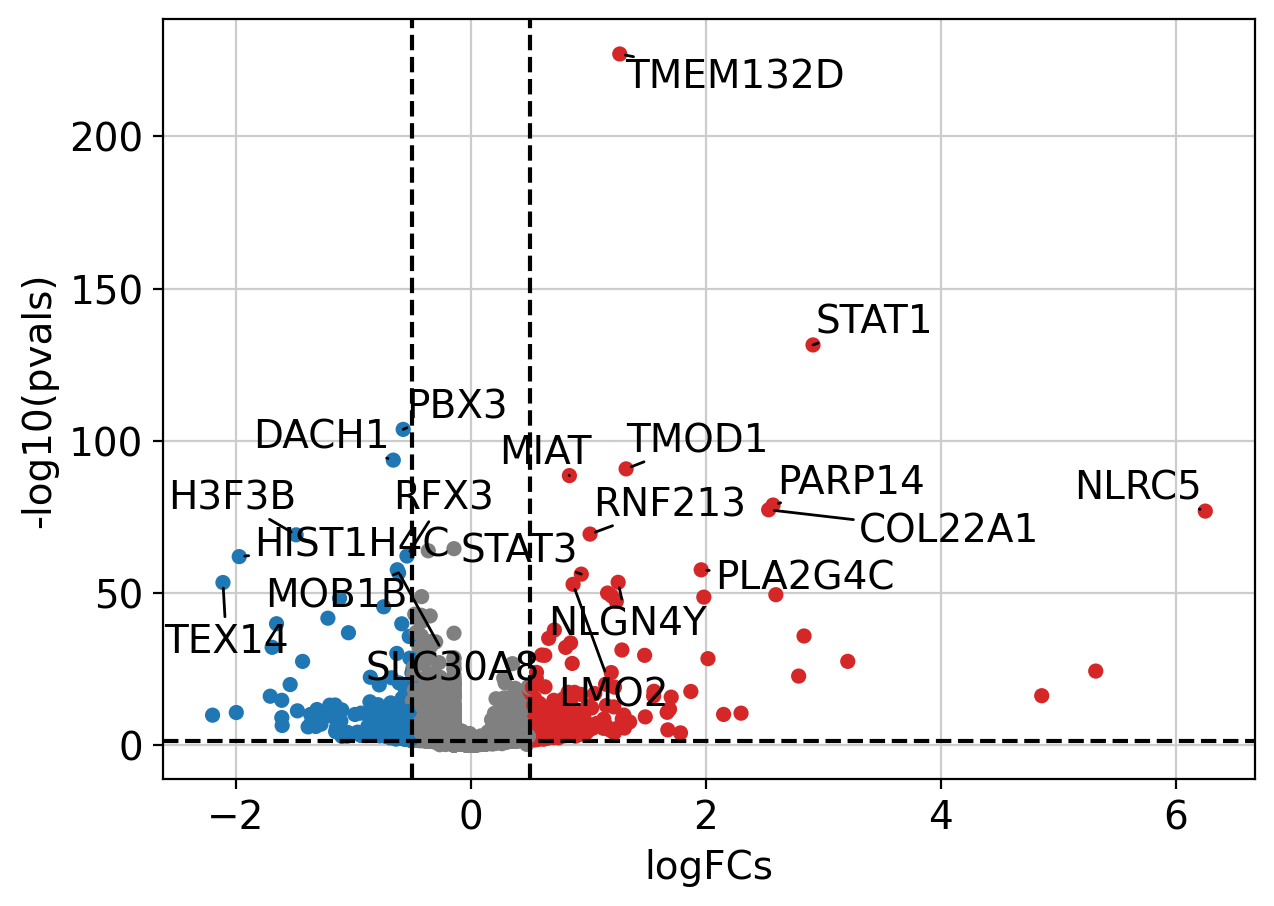

In [17]:
# For each contrast, get DESeq2 statistics and generate a few plots
for curr_contrast in contrast_factors:
    if curr_contrast == reference_value:
        continue
    else:
        curr_contrast = curr_contrast.replace("_", "-")
        print(f"Running DESeq2 for {curr_contrast} vs {reference_value}")
        stat_res = DeseqStats(dds, contrast=[reference_factor, curr_contrast, reference_value], n_cpus=n_cpus)
        stat_res.summary()
        results_df = stat_res.results_df
        results_df.sort_values("padj").to_csv(os.path.join(outdir_path, f"{curr_contrast}_vs_{reference_value}.tsv"), sep="\t")
        dc.plot_volcano_df(
            results_df, 
            x='log2FoldChange', 
            y='padj', 
            top=20, 
            save=os.path.join(outdir_path, f"volcano_plot_{curr_contrast}_vs_{reference_value}.png")
        )
        stat_res.lfc_shrink(coeff=f"{reference_factor}_{curr_contrast}_vs_{reference_value}")
        shrunk_results_df = stat_res.results_df
        shrunk_results_df.sort_values("padj").to_csv(os.path.join(outdir_path, f"{curr_contrast}_vs_{reference_value}_shrunkLFC.tsv"), sep="\t")
        dc.plot_volcano_df(
            shrunk_results_df, 
            x='log2FoldChange', 
            y='padj', 
            top=20, 
            save=os.path.join(outdir_path, f"volcano_plot_{curr_contrast}_vs_{reference_value}_shrunkLFCs.png")
        )

# DONE!

---

# Scratch